### Qcodes example notebook for Alazar card ATS9440 and acq controllers

In [1]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATSdriver
from qdev_wrappers.alazar_controllers.ATSChannelController import ATSChannelController
from qdev_wrappers.alazar_controllers.alazar_channel import AlazarChannel
#import qcodes.instrument_drivers.AlazarTech.acq_helpers as helpers
from qcodes.station import Station
import logging
logging.basicConfig(level=logging.INFO)
from qcodes.utils.dataset.doNd import do0d
import os
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
import tempfile
from qcodes.instrument.parameter import ManualParameter

In [2]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='alazar',
    sample_name='alazar-sample')

NB: See ATS9440 example notebook for general commands 

In [4]:
# Create the ATS9440 instrument
alazar = ATSdriver.AlazarTech_ATS9440(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'firmware': '7.06',
 'model': 'ATS9440',
 'max_samples': 134217728,
 'bits_per_sample': 14,
 'serial': '941144',
 'vendor': 'AlazarTech',
 'CPLD_version': '15.3',
 'driver_version': '7.3.0',
 'SDK_version': '7.3.0',
 'latest_cal_date': '16-06-20',
 'memory_size': '134217728',
 'asopc_type': 1174905920,
 'pcie_link_speed': '0.25GB/s',
 'pcie_link_width': '4'}

The Alazar driver does not directly set setting one the card but requires you to call 
sync_settings_to_card to do that. Here we use the syncing context manager to ensure that 
that method is automatically called when we are done setting the settings

In [7]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(1_000_000)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.decimation(1)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(.4)
    alazar.channel_range2(.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_operation('TRIG_ENGINE_OP_J')
    alazar.trigger_engine1('TRIG_ENGINE_J')
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_slope1('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level1(160)
    alazar.trigger_engine2('TRIG_ENGINE_K')
    alazar.trigger_source2('DISABLE')
    alazar.trigger_slope2('TRIG_SLOPE_POSITIVE')
    alazar.trigger_level2(128)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_5V')
    alazar.trigger_delay(0)
    alazar.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    alazar.aux_io_param('NONE')
    alazar.timeout_ticks(1)

## Example 1

Pulls the raw data the alazar acquires averaged over records and buffers.

In [8]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to. Explicitly pass the default options to the Alazar.
# Dont integrate over samples but avarage over records
myctrl = ATSChannelController(name='my_controller', alazar_name='Alazar')

Put the Alazar and the controller in a station so we ensure that all parameters are captured

In [9]:
station = qc.Station(alazar, myctrl)

This controller is designed to be highlevel and it is not possible to directly set number of records, buffers and samples. The number of samples is indirecly controlled by the integration time and integration delay and the number of averages controls the number of buffers and records acquired

In [10]:
myctrl.int_delay(2e-7)
myctrl.int_time(2e-7)
print(myctrl.samples_per_record())
#myctrl.num_avg(1000)

INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 0.19999999999999998 samples round up to 256
INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 0.39999999999999997 samples round up to 256


256


Per default the controller does not have any channels assiated with it.

In [11]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [])

# 1D samples trace

Lets define a channel were we avarege over buffers and records but not over samples. This will give us a time series with a x axis defined by int_time, int_delay and the sampling rate. First we create a channel and set the relevant parameters. We may choose to append the channel to the controllers build in list of channels for future reference.

In [12]:
chan1 = AlazarChannel(myctrl, 'mychan', demod=False, integrate_samples=False)
myctrl.channels.append(chan1)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 13 to 1601975960.716629
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35447d. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 13. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35447d. 


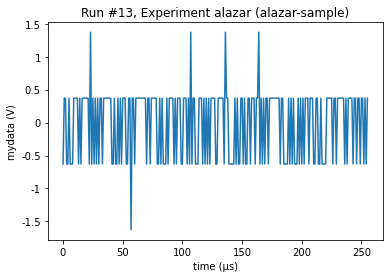

In [13]:
chan1.num_averages(1000)

chan1.alazar_channel('A')
chan1.prepare_channel()

# Measure this 
data1 = do0d(chan1.data)

We can measure the time taken to do a measurement

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 14 to 1601975963.3598661
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd354ed0. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 14. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd354ed0. 


Wall time: 811 ms


(results #14@C:\Users\WMIAdmin\AppData\Local\Temp\data_access_example.db
 -----------------------------------------------------------------------
 my_controller_mychan_time - array
 my_controller_mychan_data - array,
 [<AxesSubplot:title={'center':'Run #14, Experiment alazar (alazar-sample)'}, xlabel='time (μs)', ylabel='mydata (mV)'>],
 [None])

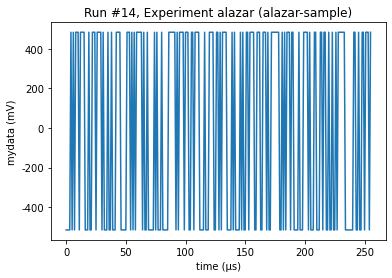

In [14]:
%%time
do0d(chan1.data)

## Demodulation

We may optionally chose to demodulate the data that we acquire using a software demodulator

In [15]:
chan1d = AlazarChannel(myctrl, 'mychan_demod_1', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d)

In [16]:
chan1d.num_averages(1000)

chan1d.alazar_channel('A')
chan1d.demod_freq(30e6)
chan1d.demod_type('magnitude')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 15 to 1601975971.8674724
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd356fe6. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 15. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 143, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_mychan_demod_1_data')

We can also get the phase

In [17]:
chan1d.demod_type('phase')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 16 to 1601975973.6453848
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3576fe. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 16. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 143, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_mychan_demod_1_data')

Or real part

In [18]:
chan1d.demod_type('real')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 17 to 1601975975.7659817
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd357f46. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 17. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 143, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_mychan_demod_1_data')

Or complex part

In [19]:
chan1d.demod_type('imag')

chan1d.prepare_channel()

# Measure this 
data1d = do0d(chan1d.data)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 18 to 1601975977.5563478
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd358645. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 18. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 143, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_mychan_demod_1_data')

We are free to add more demodulators with different frequencies

In [20]:
chan1d2 = AlazarChannel(myctrl, 'mychan_demod_2', demod=True, integrate_samples=False)
myctrl.channels.append(chan1d2)

INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 19 to 1601975982.8851144
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd359b15. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 19. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd359b15. 


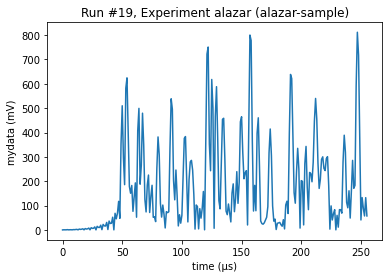

In [21]:
chan1d2.num_averages(1000)

chan1d2.alazar_channel('A')
chan1d2.demod_freq(2e6)
chan1d2.demod_type('magnitude')

chan1d2.prepare_channel()

# Measure this 
data1d = do0d(chan1d2.data)

In [22]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>])

We can get the data from multiple chanels in one provided that the shape (buffers,records,samples) is the same. The time overhead is fairly small as we are only capturing the data once.

In [23]:
%%time
data = do0d(myctrl.channels.data)

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 20 to 1601975985.0812848
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35a3b3. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 20. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 344, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_Multi_data')

In [24]:
data1 = do0d(myctrl.channels.data)

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan_demod_2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 21 to 1601975996.140469
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35ced7. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 21. 


Traceback:
Traceback (most recent call last):
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 108, in do0d
    datasaver.add_result(*_process_params_meas(param_meas))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\utils\dataset\doNd.py", line 32, in _process_params_meas
    output.append((parameter, parameter.get()))
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 597, in get_wrapper
    raise e
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument\parameter.py", line 584, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\alazar_multidim_parameters.py", line 344, in get_raw
    **acq_kwargs)
  File "C:\Users\WMIAdmin\Qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py", line 661, in acquire
    return acquisition_controller.post_acquire()
  File "c:\users\wmiadmin\qdev-wrappers\qdev_wrappers\alazar_controllers\ATSChannelController.py", line 345, in post_acquire
    self.

ValueError: ('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.', 'getting my_controller_Multi_data')

# 1D records trace

We can also do a 1D trace of records

In [25]:
chan2 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_records=False)
myctrl.channels.append(chan2)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 22 to 1601975999.2101815
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35dadb. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 22. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35dadb. 


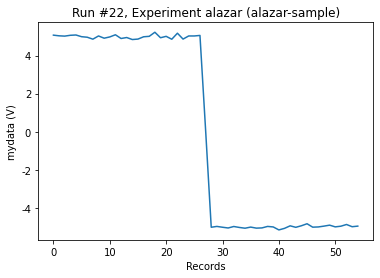

In [26]:
chan2.num_averages(100)
chan2.records_per_buffer(55)
chan2.alazar_channel('A')

chan2.prepare_channel()

# Measure this 
data2 = do0d(myctrl.channels[-1].data)

Again it is posssible to demodulate the data

In [27]:
chan2d = AlazarChannel(myctrl, 'myrecchan_D', demod=True, average_records=False)
myctrl.channels.append(chan2d)

In [28]:
print(myctrl.int_delay())
print(myctrl.int_time())

2e-07
2e-07


In [29]:
myctrl.int_time.cache.get()

2e-07

In [30]:
chan2d.alazar_channel('A')
chan2d.demod_freq(1e6)
chan2d.demod_type('magnitude')

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 23 to 1601976004.8953784
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35f110. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 23. 


C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35f110. 
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:702: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(np.abs(data_dict['data']))
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:705: RuntimeWarning: invalid value encountered in less
  if maxval < threshold:


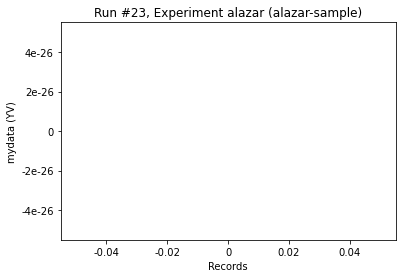

In [31]:
chan2d.num_averages(100)
chan2d.records_per_buffer(55)
chan2d.alazar_channel('A')

chan2d.prepare_channel()

# Measure this 
data2d = do0d(myctrl.channels[-1].data)

In [32]:
myctrl.channels

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, [<AlazarChannel: my_controller_mychan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_1 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_mychan_demod_2 of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>])

In [33]:
myctrl.channels[-2:]

ChannelList(<ATSChannelController: my_controller>, AlazarChannel, (<AlazarChannel: my_controller_myrecchan of ATSChannelController: my_controller>, <AlazarChannel: my_controller_myrecchan_D of ATSChannelController: my_controller>))

INFO:qcodes.dataset.measurements:Registered my_controller_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_D_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 24 to 1601976007.2364185
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35fa3e. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 55, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 24. 


C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd35fa3e. 
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:702: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(np.abs(data_dict['data']))
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:705: RuntimeWarning: invalid value encountered in less
  if maxval < threshold:


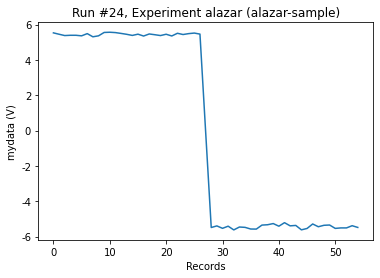

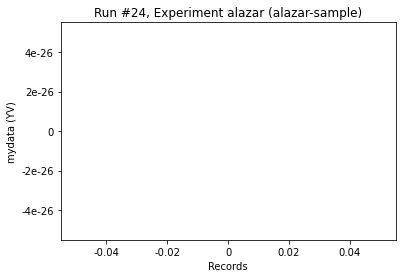

In [34]:
data = do0d(myctrl.channels[-2:].data)

# 1D Buffer trace

We can also do a 1D trace over buffers in the same way

In [35]:
chan3 = AlazarChannel(myctrl, 'myrecchan', demod=False, average_buffers=False)
myctrl.channels.append(chan3)


Since we are capturing a lot of buffers it may be needed to increase the timeout

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 25 to 1601976010.6520438
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd36078c. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 25. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd36078c. 


10000


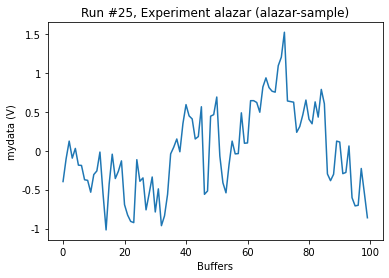

In [36]:
chan3.num_averages(100)
chan3.buffers_per_acquisition(100)
chan3.alazar_channel('A')
alazar.buffer_timeout.set(10000)
chan3.prepare_channel()

# Measure this 
data3 = do0d(chan3.data)
print(alazar.buffer_timeout())

And demodulate this

In [37]:
chan3d = AlazarChannel(myctrl, 'myrecchan_d', demod=True, average_buffers=False)
myctrl.channels.append(chan3d)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 26 to 1601976014.5891228
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3616ee. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 26. 


C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3616ee. 
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:702: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(np.abs(data_dict['data']))
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:705: RuntimeWarning: invalid value encountered in less
  if maxval < threshold:


10000


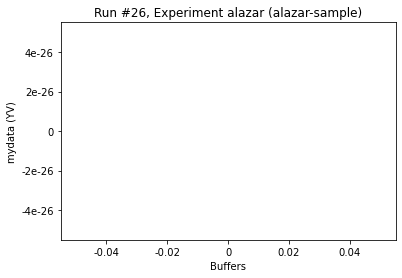

In [38]:
chan3d.num_averages(100)
chan3d.buffers_per_acquisition(100)
chan3d.alazar_channel('A')
chan3d.demod_freq(2e6)
chan3d.demod_type('magnitude')
alazar.buffer_timeout.set(10000)
chan3d.prepare_channel()

# Measure this 
data3 = do0d(chan3d.data)
print(alazar.buffer_timeout())

INFO:qcodes.dataset.measurements:Registered my_controller_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecchan_d_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 27 to 1601976018.5083952
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd362636. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 27. 


C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\WMIAdmin\anaconda3\envs\qcodes\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd362636. 
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:702: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(np.abs(data_dict['data']))
C:\Users\WMIAdmin\Qcodes\qcodes\dataset\plotting.py:705: RuntimeWarning: invalid value encountered in less
  if maxval < threshold:


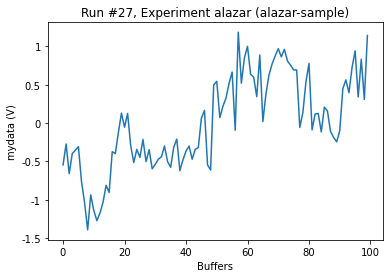

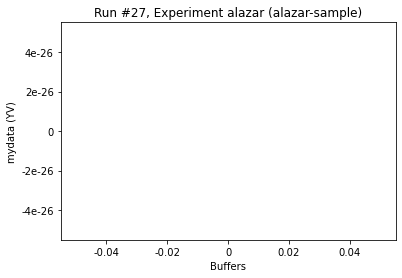

In [39]:
data = do0d(myctrl.channels[-2:].data)

# 2D Samples vs records

In [40]:
chan4 = AlazarChannel(myctrl, 'myrecvssamples', demod=False, average_records=False, integrate_samples=False)
myctrl.channels.append(chan4)

INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_myrecvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 28 to 1601976022.7642753
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3636dd. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3636dd. 


Starting experimental run with id: 28. 


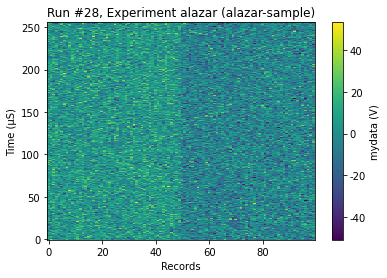

In [41]:
chan4.num_averages(1)
chan4.records_per_buffer(100)
chan4.alazar_channel('A')
chan4.prepare_channel()
# Measure this 
data4 = do0d(chan4.data)

# 2D Buffers vs Records

INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybuffersvsrecs_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 29 to 1601976027.7352698
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd364a48. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 72, 'buffers_per_acquisition': 10, 'allocated_buffers': 4}


Starting experimental run with id: 29. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd364a48. 


10000


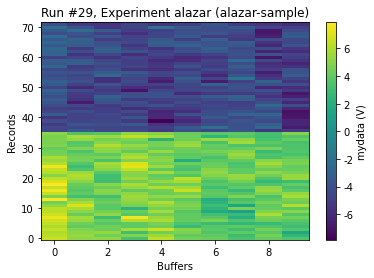

In [42]:
chan5 = AlazarChannel(myctrl, 'mybuffersvsrecs', demod=False, average_records=False, average_buffers=False)
alazar.buffer_timeout.set(10000)
chan5.records_per_buffer(72)
chan5.buffers_per_acquisition(10)
chan5.num_averages(1)
chan5.alazar_channel('A')
chan5.prepare_channel()
# Measure this
data5 = do0d(chan5.data)
print(alazar.buffer_timeout())

# 2D Buffers vs Samples

INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_buffers in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 30 to 1601976030.7026198
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3655d8. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 100, 'allocated_buffers': 4}


Starting experimental run with id: 30. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3655d8. 


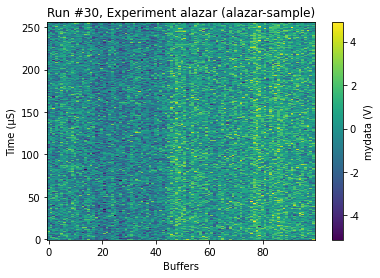

In [43]:
chan6 = AlazarChannel(myctrl, 'mybufvssamples', demod=False, average_buffers=False, integrate_samples=False)
chan6.buffers_per_acquisition(100)
chan6.num_averages(100)
chan6.alazar_channel('A')
chan6.prepare_channel()
# Measure this 
data6 = do0d(chan6.data)


# Single point

In [44]:
chan7 = AlazarChannel(myctrl, 'mybufvssamples', demod=False)


chan7.num_averages(100)
chan7.alazar_channel('A')
chan7.prepare_channel()
# Measure this

data7 = do0d(chan7.data, do_plot=False)

INFO:qcodes.dataset.measurements:Registered my_controller_mybufvssamples_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 31 to 1601976034.8224256
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3665f7. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 100, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}
INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd3665f7. 


Starting experimental run with id: 31. 


As we are not integrating over samples the setpoints (label, unit and ticks on number) are automatically set from the integration time and integration delay. **Note at the moment this does not cut of the int_delay from the plot. It probably should**

# Multiple channels

In [45]:
chan1 = AlazarChannel(myctrl, 'mychan1', demod=False, integrate_samples=False)
chan1.num_averages(1000)
chan1.alazar_channel('A')
chan1.prepare_channel()
chan2 = AlazarChannel(myctrl, 'mychan2', demod=False, integrate_samples=False)
chan2.num_averages(1000)
chan2.alazar_channel('B')
chan2.prepare_channel()
myctrl.channels.append(chan1)
myctrl.channels.append(chan2)


#plot = qc.MatPlot(data6.my_controller_mybufvssamples_data)

INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan1_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered my_controller_mychan2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 32 to 1601976041.586127
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-0174fd36804c. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 256, 'records_per_buffer': 1000, 'buffers_per_acquisition': 1, 'allocated_buffers': 1}


Starting experimental run with id: 32. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-0174fd36804c. 


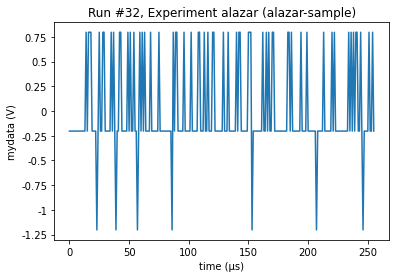

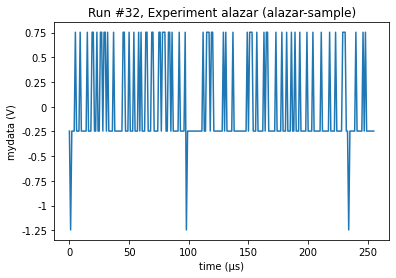

In [46]:
data7 = do0d(myctrl.channels[-2:].data)